# This is the implementation for the advanced Model

## Step 1: Load the Required Libraries
In this step, we import the necessary libraries, including PyTorch for building the model,
and other utilities for data preprocessing, loading, and splitting.

In [51]:
# Import Libraries
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score,ConfusionMatrixDisplay
import seaborn as sns

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Step 2: Load and Preprocess the Dataset
Here, we load the dataset from the CSV files and preprocess it for training the model.


In [3]:
# Load the preprocessed data from CSV files
train_data = pd.read_csv("train.csv")
val_data = pd.read_csv("val.csv")
test_data = pd.read_csv("test.csv")

In [4]:
X_train = train_data['text']
y_train = train_data['label']

X_val = val_data['text']
y_val = val_data['label']

X_test = test_data['text']
y_test = test_data['label']

## Step 3: Load Pre-trained Word2Vec Embeddings
We use pre-trained Word2Vec embeddings to represent words as dense vectors.
These embeddings improve the performance of the model by leveraging semantic relationships between words.

In [ ]:
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
from nltk.tokenize import word_tokenize

In [5]:
# Load pre-trained Word2Vec model
word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)

In [6]:
# Create a vocabulary
embedding_dim = 300
vocab = {"<PAD>": 0, "<UNK>": 1}  # Special tokens
embedding_matrix = [np.zeros(embedding_dim), np.random.uniform(-0.01, 0.01, embedding_dim)]  # Initialize <PAD> and <UNK>

In [7]:
# Build vocabulary from Word2Vec
for text in X_train:
    for word in word_tokenize(text.lower()):
        if word not in vocab and word in word2vec:
            vocab[word] = len(vocab)
            embedding_matrix.append(word2vec[word])

embedding_matrix = np.array(embedding_matrix)
vocab_size = len(vocab)

print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 76131


In [8]:
print(embedding_matrix.shape)
print(embedding_matrix[embedding_matrix.shape[0]-1])


(76131, 300)
[ 0.29492188  0.14550781 -0.27539062 -0.45117188  0.05810547  0.13867188
 -0.28125    -0.15039062  0.03369141  0.39648438  0.04785156  0.37304688
 -0.19726562 -0.13378906 -0.26367188  0.05908203  0.05200195 -0.06542969
 -0.21484375  0.13867188 -0.0480957   0.13183594  0.46875     0.34960938
 -0.04101562 -0.00198364 -0.14257812 -0.02819824  0.28515625 -0.04370117
  0.08789062 -0.09472656 -0.13671875 -0.27929688  0.10205078 -0.33789062
  0.1015625  -0.00282288 -0.42382812  0.17089844  0.03466797 -0.9765625
  0.05908203 -0.08300781 -0.234375   -0.21679688 -0.34765625  0.12158203
 -0.04663086  0.06787109 -0.70703125  0.07958984  0.10986328  0.09033203
 -0.08251953 -0.03930664 -0.66796875 -0.20117188  0.03637695  0.23535156
 -0.15039062  0.30664062 -0.19921875  0.13964844 -0.19335938  0.0291748
  0.09326172 -0.08349609  0.07421875  0.17480469 -0.13476562 -0.16894531
  0.09570312  0.328125   -0.53125     0.09521484 -0.09912109  0.08691406
 -0.28515625  0.03564453  0.05566406 -0.

## Step 4: Tokenize and Pad Sequences
Convert the text into sequences of integers based on the vocabulary.
We also pad sequences to ensure they all have the same length for batch processing.

In [9]:
# Tokenize and convert text to sequences
def text_to_sequence(text, vocab, max_len=1000):
    sequence = [vocab.get(word, vocab["<UNK>"]) for word in word_tokenize(text.lower())]
    if len(sequence) < max_len:
        sequence.extend([vocab["<PAD>"]] * (max_len - len(sequence)))
    return sequence[:max_len]

# Apply tokenization
max_len = 1000
X_train_seq = [text_to_sequence(text, vocab, max_len) for text in X_train]
X_val_seq = [text_to_sequence(text, vocab, max_len) for text in X_val]
X_test_seq = [text_to_sequence(text, vocab, max_len) for text in X_test]

## Step 5: Create a Dataset and DataLoader
We define a custom Dataset class to handle our data and create DataLoader objects
to efficiently load data during training and validation.

In [10]:
# Custom Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [11]:
# Create Dataset and DataLoader
batch_size = 32
train_dataset = TextDataset(X_train_seq, y_train)
val_dataset = TextDataset(X_val_seq, y_val)
test_dataset = TextDataset(X_test_seq, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Step 6: Define the LSTM Model
The model consists of an embedding layer initialized with Word2Vec embeddings,
followed by a Bi-Directional LSTM layer, an Attention Layer and a fully connected output layer.

In [12]:
class AdvancedLSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, attention=True):
        super(AdvancedLSTMClassifier, self).__init__()
        # Embedding layer initialized with pre-trained Word2Vec embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)

        # Bidirectional LSTM
        self.lstm = nn.LSTM(input_size=embedding_matrix.shape[1], hidden_size=hidden_dim,
                            batch_first=True, bidirectional=True)

        # Attention mechanism (optional)
        self.attention = attention
        if attention:
            self.attention_weights = nn.Linear(2 * hidden_dim, 1)  # Compute attention scores

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(2 * hidden_dim, 128)  # First dense layer
        self.fc2 = nn.Linear(128, output_dim)  # Second dense layer
        self.sigmoid = nn.Sigmoid()  # Output layer for binary classification

    def forward(self, x):
        # Step 1: Embedding layer
        x = self.embedding(x)

        # Step 2: Bidirectional LSTM
        lstm_out, _ = self.lstm(x)  # lstm_out shape: [batch_size, seq_len, 2 * hidden_dim]

        # Step 3: Attention mechanism (if enabled)
        if self.attention:
            attention_scores = self.attention_weights(lstm_out).squeeze(-1)  # [batch_size, seq_len]
            attention_weights = torch.softmax(attention_scores, dim=1)  # Normalize scores
            x = torch.bmm(attention_weights.unsqueeze(1), lstm_out).squeeze(1)  # Weighted sum of LSTM outputs
        else:
            x = lstm_out[:, -1, :]  # Use the last hidden state if no attention

        # Step 4: Fully connected layers
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc1(x))  # First dense layer with ReLU activation
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Second dense layer

        # Step 5: Output layer
        return self.sigmoid(x)


## Step 7: Initialize the Model 
We initialize the model with the embedding matrix, hidden dimension, and output dimension.

In [13]:
hidden_dim = 128
output_dim = 1
model = AdvancedLSTMClassifier(embedding_matrix, hidden_dim, output_dim, attention=True).to(device)

## Step 7: Train the Model
We train the model using the training and validation datasets and monitor the loss and accuracy.
To calculate the loss, we use the Binary Cross-Entropy loss function.
We use the Adam optimizer to update the model parameters based on the gradients.
To prevent overfitting, we make use of early stopping and learning rate scheduling.


In [16]:
def train_model(model, train_loader, val_loader, epochs=15, learning_rate=0.0005):
    # Existing initialization code remains the same until the training loop
    metrics_history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': [],
        'train_f1': [], 'val_f1': [],
        'learning_rates': []
    }
    
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-6, verbose=True
    )

    best_model_state = None
    best_val_loss = float('inf')
    patience = 4
    patience_counter = 0
    
    num_warmup_steps = 100
    def get_lr(step):
        if step < num_warmup_steps:
            return learning_rate * (step / num_warmup_steps)
        return learning_rate

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 50)

        # Training phase
        model.train()
        train_predictions = []
        train_true_labels = []
        total_train_loss = 0

        for i, (texts, labels) in enumerate(train_loader):
            current_lr = get_lr(epoch * len(train_loader) + i)
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr

            texts = texts.to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(texts).squeeze(1)

            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_train_loss += loss.item()

            # Store predictions and true labels
            predicted = torch.round(outputs.detach())
            train_predictions.extend(predicted.cpu().numpy())
            train_true_labels.extend(labels.cpu().detach().numpy())

            if (i + 1) % 50 == 0:
                print(f"Batch {i+1}/{len(train_loader)}: Loss: {loss.item():.4f}")

        # Calculate training metrics
        train_acc = accuracy_score(train_true_labels, train_predictions)
        train_precision = precision_score(train_true_labels, train_predictions)
        train_recall = recall_score(train_true_labels, train_predictions)
        train_f1 = f1_score(train_true_labels, train_predictions)
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation phase
        val_loss, val_metrics = evaluate_model(model, val_loader, criterion)

        # Store metrics
        metrics_history['train_loss'].append(avg_train_loss)
        metrics_history['val_loss'].append(val_loss)
        metrics_history['train_acc'].append(train_acc)
        metrics_history['val_acc'].append(val_metrics['accuracy'])
        metrics_history['train_precision'].append(train_precision)
        metrics_history['val_precision'].append(val_metrics['precision'])
        metrics_history['train_recall'].append(train_recall)
        metrics_history['val_recall'].append(val_metrics['recall'])
        metrics_history['train_f1'].append(train_f1)
        metrics_history['val_f1'].append(val_metrics['f1'])
        metrics_history['learning_rates'].append(current_lr)

        # Print epoch metrics
        print(f"\nEpoch {epoch+1} Results:")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Training Metrics: Acc={train_acc:.4f}, Prec={train_precision:.4f}, Rec={train_recall:.4f}, F1={train_f1:.4f}")
        print(f"Validation Metrics: Acc={val_metrics['accuracy']:.4f}, Prec={val_metrics['precision']:.4f}, Rec={val_metrics['recall']:.4f}, F1={val_metrics['f1']:.4f}")
        print(f"Learning Rate: {current_lr}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            torch.save(best_model_state, 'best_mlp_model.pth')
            print("► Saved new best model")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("\nEarly stopping triggered!")
                model.load_state_dict(best_model_state)
                break

        scheduler.step(val_metrics['accuracy'])

    return metrics_history

## Step 8: Evaluate the Model
This method evaluates the model on the validation and test sets 

In [ ]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in data_loader:
            texts = texts.to(device)
            labels = labels.float().to(device)

            outputs = model(texts).squeeze()

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predicted = torch.round(outputs)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    metrics = {
        'accuracy': accuracy_score(all_labels, all_predictions),
        'precision': precision_score(all_labels, all_predictions),
        'recall': recall_score(all_labels, all_predictions),
        'f1': f1_score(all_labels, all_predictions)
    }

    return total_loss / len(data_loader), metrics

## Step 9: Plot Training History
We plot the training history to visualize the loss, accuracy, precision, recall, and F1 score over epochs.


In [44]:
def plot_training_history(metrics_history):
    # Set up the style
    # plt.style.use('seaborn')

    # Create a figure with multiple subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot losses
    ax1.plot(metrics_history['train_loss'], label='Training Loss')
    ax1.plot(metrics_history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracies
    ax2.plot(metrics_history['train_acc'], label='Training Accuracy')
    ax2.plot(metrics_history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Plot precision and recall
    ax3.plot(metrics_history['train_precision'], label='Training Precision')
    ax3.plot(metrics_history['val_precision'], label='Validation Precision')
    ax3.plot(metrics_history['train_recall'], label='Training Recall')
    ax3.plot(metrics_history['val_recall'], label='Validation Recall')
    ax3.set_title('Precision and Recall Over Time')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Score')
    ax3.legend()

    # Plot F1 scores
    ax4.plot(metrics_history['train_f1'], label='Training F1')
    ax4.plot(metrics_history['val_f1'], label='Validation F1')
    ax4.set_title('F1 Score Over Time')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('F1 Score')
    ax4.legend()

    plt.tight_layout()
    plt.show()

## Step 10: Plot the Confusion Matrix
We plot the confusion matrix to visualize the model's performance on the test set.

In [45]:
def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in test_loader:
            texts = texts.to(device)
            outputs = model(texts).squeeze(-1)
            predicted = torch.round(torch.sigmoid(outputs))
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions))

## Step 11: Train the Model
We train the model using the training and validation datasets and monitor the loss and accuracy.
This process may take a while, depending on the number of epochs and the complexity of the model.

In [19]:
metrics_history = train_model(model, train_loader, val_loader, epochs=15, learning_rate=5e-4)



Epoch 1/15
--------------------------------------------------
Batch 50/783: Loss: 0.5700
Batch 100/783: Loss: 0.1399
Batch 150/783: Loss: 0.2009
Batch 200/783: Loss: 0.0918
Batch 250/783: Loss: 0.1246
Batch 300/783: Loss: 0.1793
Batch 350/783: Loss: 0.1967
Batch 400/783: Loss: 0.0730
Batch 450/783: Loss: 0.1269
Batch 500/783: Loss: 0.0131
Batch 550/783: Loss: 0.0212
Batch 600/783: Loss: 0.0210
Batch 650/783: Loss: 0.0050
Batch 700/783: Loss: 0.0382
Batch 750/783: Loss: 0.0140

Epoch 1 Results:
Training Loss: 0.1472
Validation Loss: 0.0354
Training Metrics: Acc=0.5254, Prec=0.5254, Rec=1.0000, F1=0.6888
Validation Metrics: Acc=0.5253, Prec=0.5253, Rec=1.0000, F1=0.6888
Learning Rate: 0.0005
► Saved new best model

Epoch 2/15
--------------------------------------------------
Batch 50/783: Loss: 0.0020
Batch 100/783: Loss: 0.0066
Batch 150/783: Loss: 0.0360
Batch 200/783: Loss: 0.0018
Batch 250/783: Loss: 0.0015
Batch 300/783: Loss: 0.0029
Batch 350/783: Loss: 0.0001
Batch 400/783: Loss

## Step 12: Evaluate the Model
plot the training history and evaluate the model on the test set.

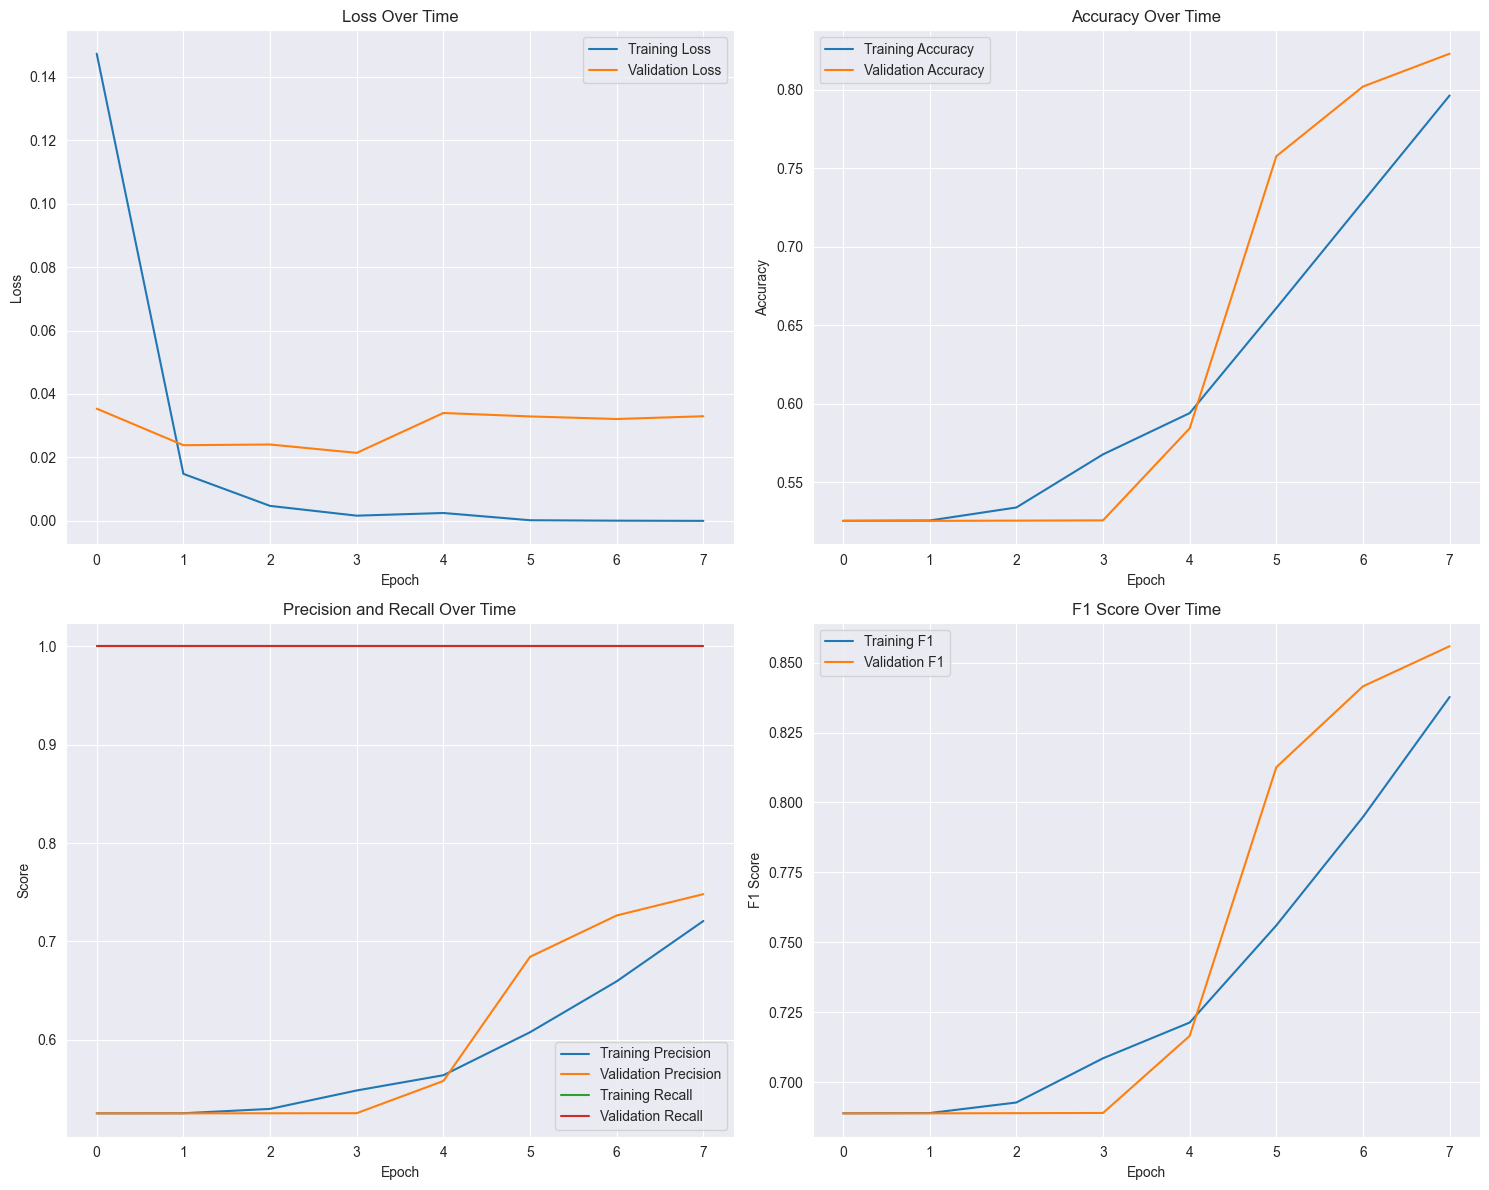

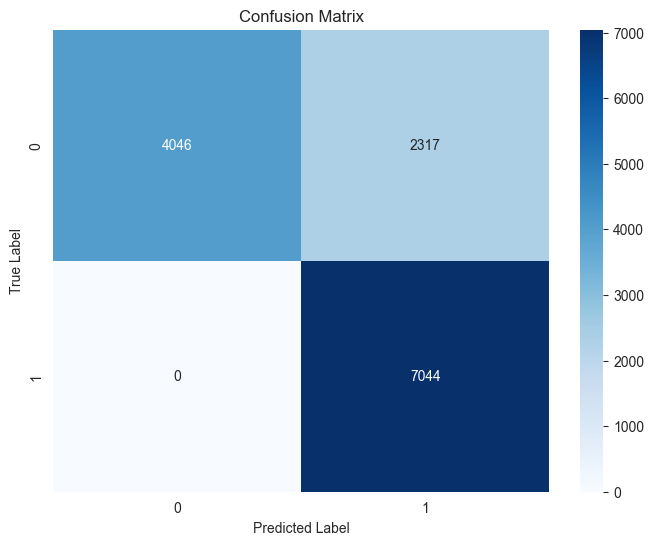


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.64      0.78      6363
         1.0       0.75      1.00      0.86      7044

    accuracy                           0.83     13407
   macro avg       0.88      0.82      0.82     13407
weighted avg       0.87      0.83      0.82     13407



In [46]:
plot_training_history(metrics_history)
plot_confusion_matrix(model, test_loader)

### plot the loss over epochs

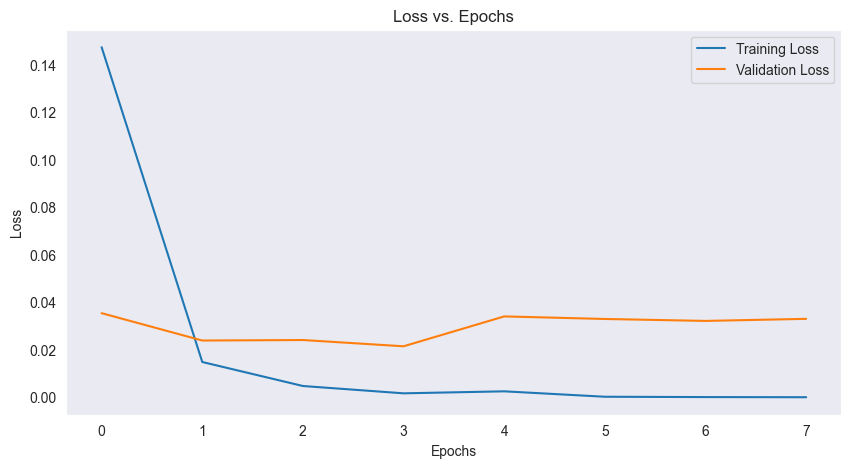

<Figure size 640x480 with 0 Axes>

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_history['train_loss'], label='Training Loss')
plt.plot(metrics_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid()
plt.show()
plt.savefig("loss_vs_epochs_first try.png")  # Save the current plot


### plot the ccuracy over epochs

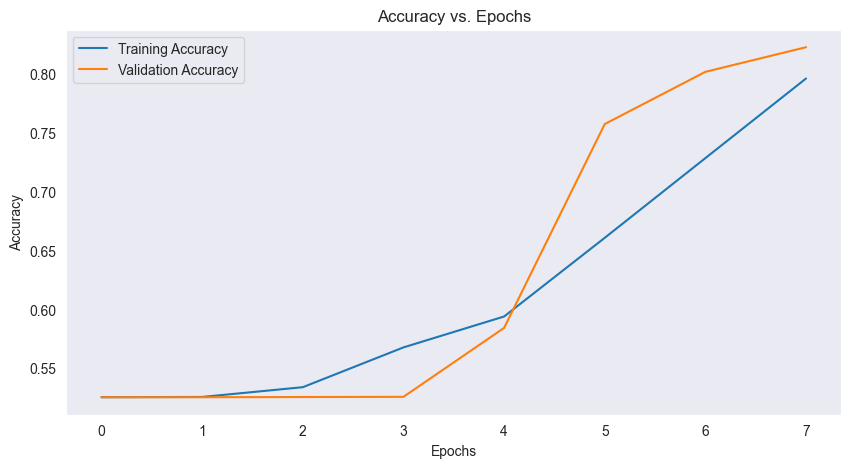

<Figure size 640x480 with 0 Axes>

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_history['train_acc'], label='Training Accuracy')
plt.plot(metrics_history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.grid()
plt.show()
plt.savefig("accuracy_vs_epochs_first_try.png")  # Save the current plot

### plot the precision, recall and f1-score over epochs

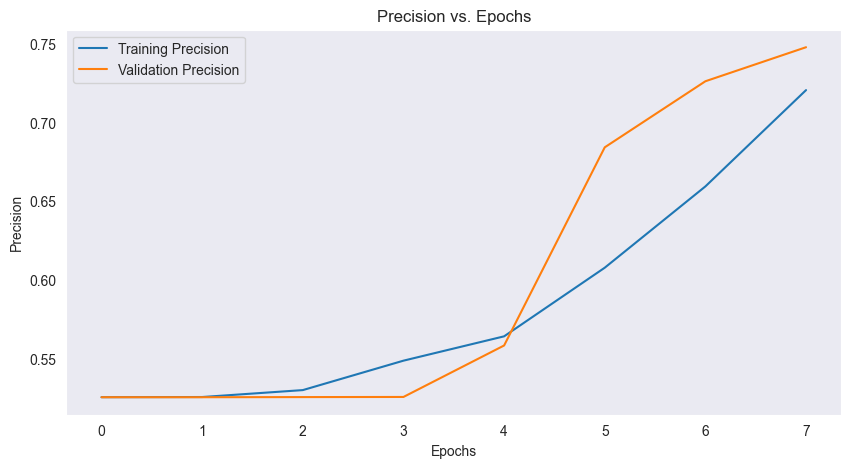

<Figure size 640x480 with 0 Axes>

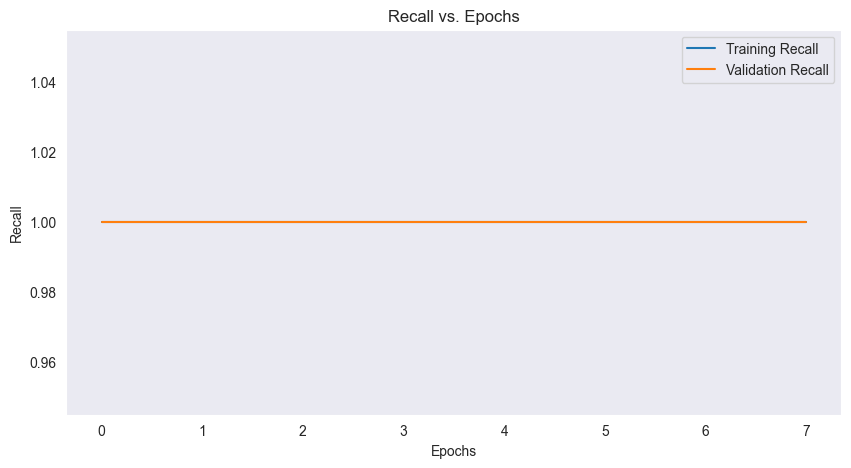

<Figure size 640x480 with 0 Axes>

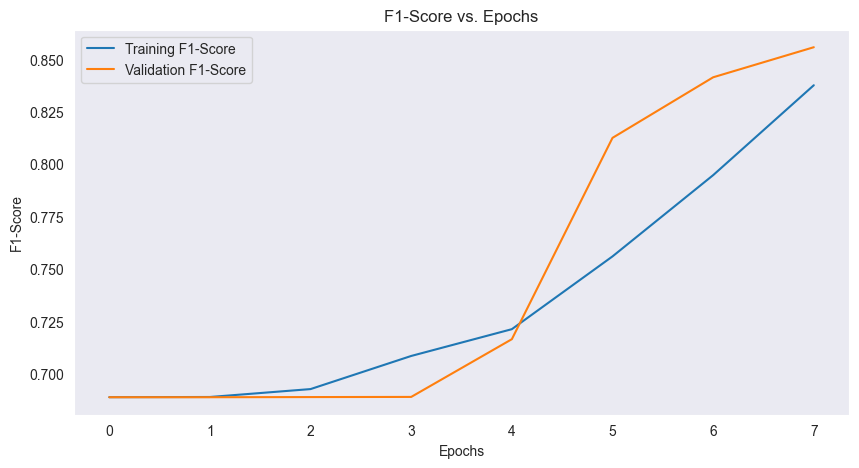

<Figure size 640x480 with 0 Axes>

In [39]:
# Precision
plt.figure(figsize=(10, 5))
plt.plot(metrics_history['train_precision'], label='Training Precision')
plt.plot(metrics_history['val_precision'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision vs. Epochs')
plt.legend()
plt.grid()
plt.show()
plt.savefig("precision_vs_epochs_first_try.png")  # Save the current

# Recall
plt.figure(figsize=(10, 5))
plt.plot(metrics_history['train_recall'], label='Training Recall')
plt.plot(metrics_history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall vs. Epochs')
plt.legend()
plt.grid()
plt.show()
plt.savefig("recall_vs_epochs_first_try.png")  # Save the current plot

# F1-Score
plt.figure(figsize=(10, 5))
plt.plot(metrics_history['train_f1'], label='Training F1-Score')
plt.plot(metrics_history['val_f1'], label='Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs')
plt.legend()
plt.grid()
plt.show()
plt.savefig("f1_score_vs_epochs_first_try.png")  # Save the current plot


## Step 14: Print out the final evaluation metrics

In [49]:
# Test the model
model.eval()
with torch.no_grad():
    test_predictions, test_labels = [], []
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        predictions = model(texts).squeeze()
        predictions = torch.round(torch.sigmoid(predictions))
        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.8272
Test Precision: 0.7525
Test Recall: 1.0000
Test F1 Score: 0.8588


## Step 13: Save the Model
### this step saves the training history to a JSON file and the model to a .pth file.

In [ ]:
import json

# Save metrics history to a JSON file
with open("images/Advanced Model/First Training Results/metrics_history.json", "w") as f:
    json.dump(metrics_history, f)

### Save the final state of the model

In [50]:
# Save the model
torch.save(model.state_dict(), "lstm_model.pth")